In [ ]:
# -*- coding: utf-8 -*-
"""stress_Si_battery.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Xd0Uil1DBV7NxP5S2fUagNCbYnnDNSG-
"""

# -*- coding: utf-8 -*-
"""basic_alpha.py

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1OVPrpKWy_hcdDL3DjsHCmQcEI8KAXbHc
"""

! pip install pyDOE
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio

import torch
import torch.autograd as autograd  # computation graph
from torch import Tensor  # tensor node in the computation graph
import torch.nn as nn  # neural networks
import torch.optim as optim  # optimizers e.g. gradient descent, ADAM, etc.
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
# from sklearn.model_selection import train_test_split
# from google.colab import files

import numpy as np
import time
from pyDOE import lhs  # Latin Hypercube Sampling
# import scipy.io
from scipy import stats
import math
from scipy.integrate import simps
from scipy.interpolate import interp1d
# import rfunctions as rf
import pandas as pd

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

"""#hyper parameters"""

steps = 20000
lr = 1e-3
layers = np.array([2, 32, 32, 1])  # hidden layers
# To generate new data:
x_min = 0
x_max = 1
t_min = 0
t_max = 150
radius0 = 300e-9
radius2 = 700e-9
# b1 = 0.005
# b2 = 0.005
Cin = 0
Cout = 1
# Nr = 400

'''stress parameters'''
# Contants
r0=radius0
r2=radius2
Om = 9e-6
gamma=0
v=0.28
d0=0.278e-9
tau=3
# BLOS theory
z1=4*(1-(0.75*d0)/(r2-r0))
z2=z1+2
z3=12
# m=4.88
B1=2/(1+np.exp((12-z1)/(8*z1)))
B2=2/(1+np.exp((12-z2)/(8*z2)))
B3=2/(1+np.exp((12-z3)/(8*z3)))
chis=((tau*d0)/(r2-r0))*(B1*((B1)**(7.88)-1)+B2*((B2)**(7.88)-1)+B3*((B3)**(7.88)-1))
q=1
chiss=chis*q
D=10e-16
E1=18.90
E2=90.13
chi1=4.4
chi=3.75
E=(90.13e9)*(1+((E1-E2)/(E2*chi1))*chi)*(1+chiss)
K=0

"""#Concentration function"""

# function for calculating first term
def f1(x, r0, r2, c1, c2,phi):
    return (r0 * c1 * np.sinh(phi*(1-x)) + r2*c2*np.sinh(phi*x))/( (r0 + x * (r2 - r0)) * np.sinh(phi))


# function for calculating second term used in summation
def f2(x, r0, r2, c1, c2, n, a, t, phi):
    return ((2 / ((r0 + x * (r2 - r0)) )) * ((r2 * c2 * ((-1) ** n)) - r0 * c1) * (n*torch.pi)*(
        np.exp(-(((n ** 2) * (torch.pi ** 2) +phi**2)* a * t))) * np.sin(n * torch.pi * x)) / ( (n**2)* (torch.pi **2) + phi**2)


# function for calculating concentration at given values of r,r0,r2,t
def conc(x, t):
    r0 = radius0
    r2 = radius2
    D = 10 ** -16  # diffusion coefficient
    c1 = Cin  # inner concentration-a
    c2 = Cout  # outer concentration
    k = 10 ** -11
    a = D / ((r2 - r0) ** 2)  # alpha
    phi = np.sqrt(k / a)
    arr = []
    for n in range(1, 50):
        arr.append(f2(x, r0, r2, c1, c2, n, a, t, phi))

    sf = sum(arr)
    return f1(x, r0, r2, c1, c2,phi) + sf


"""#PINN model"""
class FCN(nn.Module):
    ##Neural Network
    def __init__(self, layers):
        super().__init__()  # call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        self.layers = layers
        'loss function'
        self.loss_function = nn.MSELoss(reduction='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.iter = 0  # For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'

    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    'Loss Functions'

    # Loss BC
    def lossBC(self, x_BC, y_BC, layers):
        loss_BC = self.loss_function(self.forward(x_BC), y_BC)
        return loss_BC

    # Loss PDE
    def lossPDE(self, x_PDE, f_hat, layers):
        r0 = radius0
        r2 = radius2
        k = 10 ** -11
        D = 10 ** -16
        a = D / ((r2 - r0) ** 2)
        g = x_PDE.clone()
        g.requires_grad = True  # Enable differentiation
        f = self.forward(g)
        f_x_t = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]  # first derivative
        f_xx_tt = autograd.grad(f_x_t, g, torch.ones(g.shape).to(device), create_graph=True)[0]  # second derivative
        f_t = f_x_t[:, [1]]  # we select the 2nd element for t (the first one is x) (Remember the input X=[x,t])
        f_x = f_x_t[:, [0]]
        f_xx = f_xx_tt[:, [0]]  # we select the 1st element for x (the second one is t) (Remember the input X=[x,t])
        f = f_t - a * f_xx - (2 * D / (r0 * (r2 - r0) + g[:, 0:1] * (r2 - r0) * (r2 - r0)) - k) * f_x
        return self.loss_function(f, f_hat)

    def loss(self, x_BC, y_BC, x_PDE, f_hat, layers, w):
        loss_bc = self.lossBC(x_BC, y_BC, layers)
        loss_pde = self.lossPDE(x_PDE, f_hat, layers)
        return w*loss_bc + loss_pde

    def rel_loss(self, x_BC, y_BC, x_PDE, f_hat, layers):
        loss_bc = self.lossBC(x_BC, y_BC, layers)
        loss_pde = self.lossPDE(x_PDE, f_hat, layers)
        return torch.sqrt(loss_bc / loss_pde)

    # Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf
    def closure(self, f_hat, layers):
        optimizer.zero_grad()
        loss = self.loss(X_train_Nu, Y_train_Nu, X_train_Nf, f_hat, layers)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            loss2 = self.lossBC(X_test, Y_test)
            print("Training Error:", loss.detach().cpu().numpy(), "---Testing Error:", loss2.detach().cpu().numpy())
        return loss



csv_file = 'radial_stress_300_700_with_surface_effects_par.csv'
df = pd.read_csv(csv_file, header=None)

stress_values = df.iloc[:, 2].values
min_value = np.min(stress_values)
max_value = np.max(stress_values)
stress_values = (stress_values - min_value) / (max_value - min_value) #normalised


# Now you have the stress values in a mesh grid format
# print("stress_grid: ", stress_grid)

"""## **Parameter array**"""
# Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu_arr = [1000,5000,1000]
Nf_arr = [10000]
Nr_arr = [100]
weights =[0.1, 0.01 ,0.001 , 0.0001, 0.1, 1, 10] #best 0.01
# times = [50]
count = 0
f = open('output.txt' , 'a')
for Nr in Nr_arr:
    for Nf in Nf_arr:
        for Nu in Nu_arr:
            for w in weights:
                # for tim in times:
                    count += 1
                    print('----------------------------- case:', count, '----------------------------')
                    total_points_x = Nr
                    total_points_t = Nr
                    x = torch.linspace(x_min, x_max, total_points_x).view(-1, 1)
                    t = torch.linspace(t_min, t_max, total_points_t).view(-1, 1)
                    X, T = torch.meshgrid(x.squeeze(1), t.squeeze(1))
                    stress_grid = torch.tensor(stress_values.reshape(Nr, Nr)).T
                    # print("X: " ,X)
                    # print("T: " ,T)
                    # Evaluate real function
                    y_real = conc(X, T)
                    x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], T.transpose(1, 0).flatten()[:, None]))
                    # y_test = y_real.transpose(1, 0).flatten()[:, None]  # Colum major Flatten (so we transpose it)
                    y_test = torch.tensor(stress_values, dtype=torch.float32).view(-1, 1)
                    # print("x_test: ", y_test.shape)

                    # Domain bounds
                    lb = x_test[0]  # first value
                    ub = x_test[-1]  # last value
                    left_X = torch.hstack((X[:, 0][:, None], T[:, 0][:,None]))  # First column # The [:,None] is to give it the right dimension
                    # left_Y = torch.zeros(left_X.shape[0], 1)
                    left_Y = stress_grid[:, 0].view(-1, 1)
                    # Boundary Conditions
                    # Bottom Edge: x=min; tmin=<t=<max
                    bottom_X = torch.hstack((X[0, :][:, None], T[0, :][:, None]))  # First row # The [:,None] is to give it the right dimension
                    # bottom_Y = Cin*torch.ones(bottom_X.shape[0], 1)
                    bottom_Y = stress_grid[0, :].view(-1, 1)
                    # Top Edge: x=max; 0=<t=<1
                    top_X = torch.hstack((X[-1, :][:, None], T[-1, :][:, None]))  # Last row # The [:,None] is to give it the right dimension
                    # top_Y = Cout * torch.ones(top_X.shape[0], 1)
                    top_Y = stress_grid[-1, :].view(-1, 1)
                    # Get all the training data into the same dataset
                    X_train = torch.vstack([left_X, bottom_X, top_X])
                    Y_train = torch.vstack([left_Y, bottom_Y, top_Y])
                    # Choose(Nu) points of our available training data:

                    X_flat = X.t().flatten().view(-1, 1)  # Transpose to match your original dimension arrangement
                    T_flat = T.t().flatten().view(-1, 1)
                    X_train = torch.hstack((X_flat, T_flat))  # Combine into a single tensor

                    # Flatten the stress grid to create target values for each point in the mesh
                    Y_train = stress_grid.flatten().view(-1, 1)
                    idx = np.random.choice(X_train.shape[0], Nu, replace=False)

                    # Convert numpy array to a PyTorch tensor
                    idx_tensor = torch.from_numpy(idx).long()

                    # Use the indices to create the subsets
                    X_train_Nu = x_test[idx_tensor]
                    Y_train_Nu = y_test[idx_tensor]
                    # print("X_train_Nu.shape: ",X_train_Nu.shape)
                    # print("Y_train_Nu.shape: ",Y_train_Nu.shape)
                    # Collocation Points (Evaluate our PDe)
                    # Choose(Nf) points(Latin hypercube)
                    X_train_Nf = lb + (ub - lb) * lhs(2, Nf)  # 2 as the inputs are x and t
                    # sample = X_train_Nf.random(n=Nf)
                    X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))  # Add the training poinst to the collocation points
                    torch.manual_seed(123)
                    # Store tensors to GPU
                    X_train_Nu = X_train_Nu.float().to(device)  # Training Points (BC)
                    Y_train_Nu = Y_train_Nu.float().to(device)  # Training Points (BC)
                    X_train_Nf = X_train_Nf.float().to(device)  # Collocation Points
                    f_hat = torch.zeros(X_train_Nf.shape[0], 1).to(device)  # to minimize function

                    X_test = x_test.float().to(device)  # the input dataset (complete)
                    Y_test = y_test.float().to(device)  # the real solution
                    # Create Model
                    PINN = FCN(layers)
                    PINN.to(device)
                    # print(PINN)
                    params = list(PINN.parameters())
                    optimizer = torch.optim.Adam(PINN.parameters(), lr=lr, amsgrad=False)
                    '''
                    'L-BFGS Optimizer'
                    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
                                                  max_iter = steps,
                                                  max_eval = None,
                                                  tolerance_grad = 1e-05,
                                                  tolerance_change = 1e-09,
                                                  history_size = 100,
                                                  line_search_fn = 'strong_wolfe')'''
                    start_time = time.time()

                    print("total_points_x : " + str(total_points_x))
                    f.write("total_points_x : " + str(total_points_x) + '\n')
                    print("total_points_t : " + str(total_points_t))
                    f.write("total_points_t : " + str(total_points_t) + '\n')
                    print("Nu : " + str(Nu))
                    f.write("Nu : " + str(Nu) +'\n')
                    print("Nf : " + str(Nf))
                    print("lambda:" + str(w))
                    # print("time:" + str(tim))
                    f.write("Nf : " + str(Nf)+'\n')
                    f.write("lambda:" + str(w)+'\n')
                    # f.write("time:" +str(tim) + '\n')

                    for iter in range(4):
                      # a_rel = 0
                      a_train = 0
                      a_test = 0
                      v = 10
                      print('iteration no.:', iter + 1)
                      f.write('iteration no.:' + str(iter + 1))
                      f.write('\n')
                      ## start
                      for i in range(steps):
                          if i == 0:
                              print("Training Loss-----Test Loss")
                              f.write("Training Loss-----Test Loss" + '\n')
                          loss = PINN.loss(X_train_Nu, Y_train_Nu, X_train_Nf, f_hat, layers, w)  # use mean squared error
                          # rel_er = PINN.rel_loss(X_train_Nu, Y_train_Nu, X_train_Nf, f_hat, layers)  # .
                          optimizer.zero_grad()
                          loss.backward()
                          # rel_er.backward()
                          optimizer.step()
                          with torch.no_grad():
                            test_loss = PINN.lossBC(X_test, Y_test, layers)
                          if i % (steps / 10) == 0:
                              # re = rel_er.detach().cpu().numpy()  # rel. error
                              tre = loss.detach().cpu().numpy()  # training error
                              te = test_loss.detach().cpu().numpy()  # test error

                              # a_rel = a_rel + re
                              a_train = a_train + tre
                              a_test = a_test + te

                              print(tre, '---', te)
                              f.write(str(tre) + '---' + str(te))
                              f.write('\n')
                      print("Average losses:")
                      f.write("Average losses:"+'\n')
                      print(round(a_train / v, 15),'---', round(a_test / v, 9))
                      f.write(str(round(a_train / v, 15)) + '---' + str(round(a_test / v, 9)))
                      f.write('\n')
                      ## end
                      y1_all = PINN(X_test)
                      x1_all = np.ravel(X_test[:, 0].detach().cpu().numpy())
                      # t1 = torch.ones(X_test[:, 1].size())
                      t1_all = np.ravel(X_test[:, 1].detach().cpu().numpy())
                      y1_all= np.ravel(y1_all.detach().cpu().numpy())

                      # Create a DataFrame using pandas
                      data = {
                          'x values': x1_all,
                          't values': t1_all,
                          'stress values': y1_all
                      }

                      df = pd.DataFrame(data)

                      # Specify the file name
                      file_name = f'output_{w}_{iter}.csv'

                      # Save the DataFrame to a CSV file
                      df.to_csv(file_name, index=False)

                      print(f'Data saved to {file_name}')





cuda
----------------------------- case: 1 ----------------------------
total_points_x : 100
total_points_t : 100
Nu : 1000
Nf : 10000
lambda:0.1
iteration no.: 1
Training Loss-----Test Loss
0.015137355 --- 0.10103493
0.00024744667 --- 0.0019338932
0.00014363075 --- 0.00096740806
0.00010161541 --- 0.0005100225
0.00038131847 --- 0.0023289921
7.2421695e-05 --- 0.00018502273
6.328569e-05 --- 8.912288e-05
5.9812057e-05 --- 5.2372325e-05
5.8835e-05 --- 4.312293e-05
5.8416277e-05 --- 3.8296763e-05
Average losses:
0.001632413687548 --- 0.010718319
Data saved to output_0.1_0.csv
iteration no.: 2
Training Loss-----Test Loss
6.0835304e-05 --- 6.0246333e-05
6.2977575e-05 --- 9.574952e-05
7.673052e-05 --- 0.00020372447
6.248134e-05 --- 8.946562e-05
6.638302e-05 --- 9.3365736e-05
5.7495592e-05 --- 3.389637e-05
7.291393e-05 --- 9.667248e-05
5.9377806e-05 --- 5.455948e-05
6.4707376e-05 --- 7.3285395e-05
6.069918e-05 --- 7.384131e-05
Average losses:
6.446016414e-05 --- 8.7481e-05
Data saved to output_

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file = 'radial_stress_300_700_with_surface_effects_par.csv'
df = pd.read_csv(csv_file, header=None)

# Normalize the first column (x values)
x_values = df.iloc[:, 0].values
min_x = np.min(x_values)
max_x = np.max(x_values)
normalized_x_values = (x_values - min_x) / (max_x - min_x)

# Replace the original x values with the normalized x values
df.iloc[:, 0] = normalized_x_values

# Normalize the third column (stress values)
stress_values = df.iloc[:, 2].values
min_stress = np.min(stress_values)
max_stress = np.max(stress_values)
normalized_stress_values = (stress_values - min_stress) / (max_stress - min_stress)

# Replace the original stress values with the normalized stress values
df.iloc[:, 2] = normalized_stress_values

In [ ]:
csv_file = 'output_0.0001_3.csv'
df_pred = pd.read_csv(csv_file)

# Normalize the first column (x values)
x_values = df_pred.iloc[:, 0].values

# Normalize the third column (stress values)
stress_values = df_pred.iloc[:, 2].values



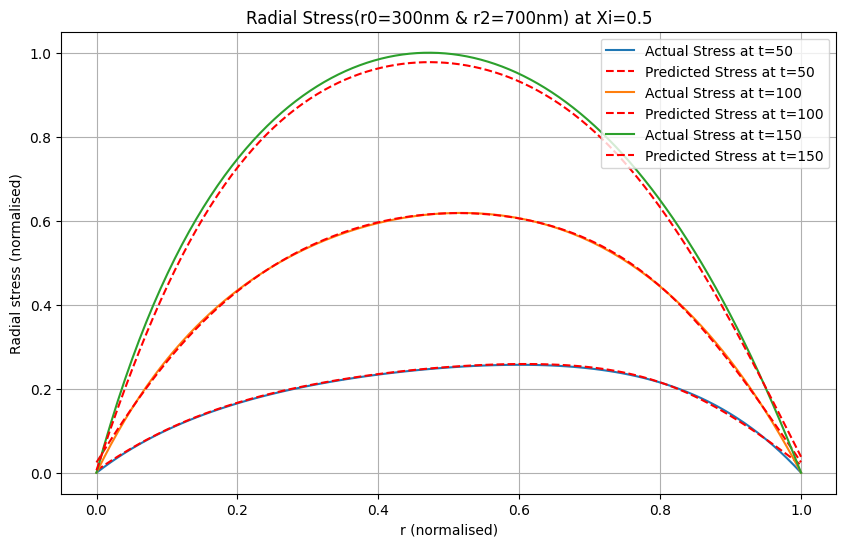

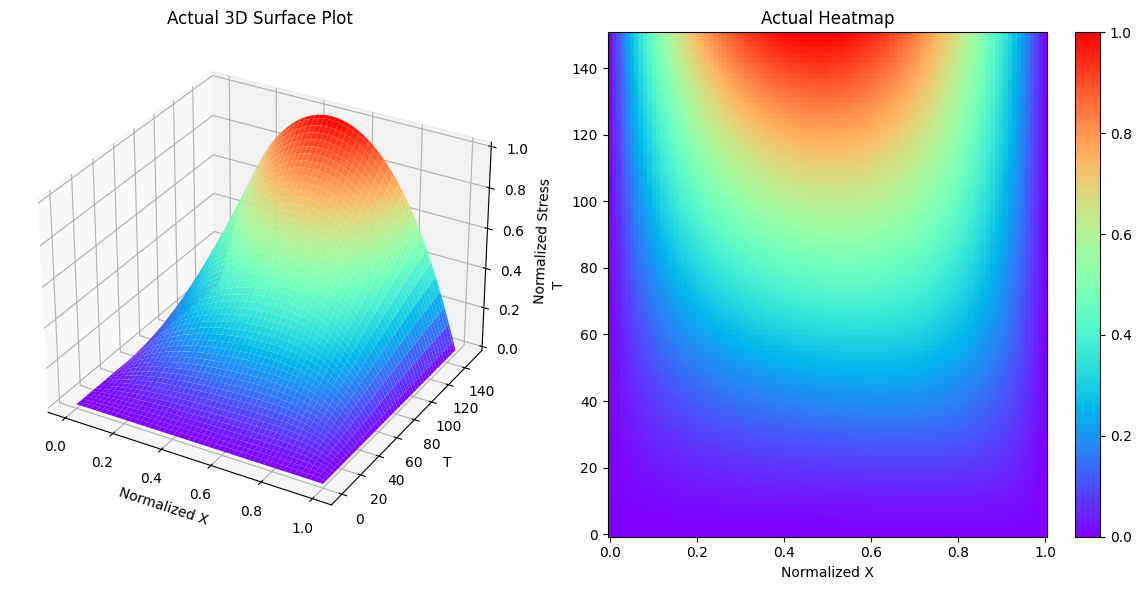

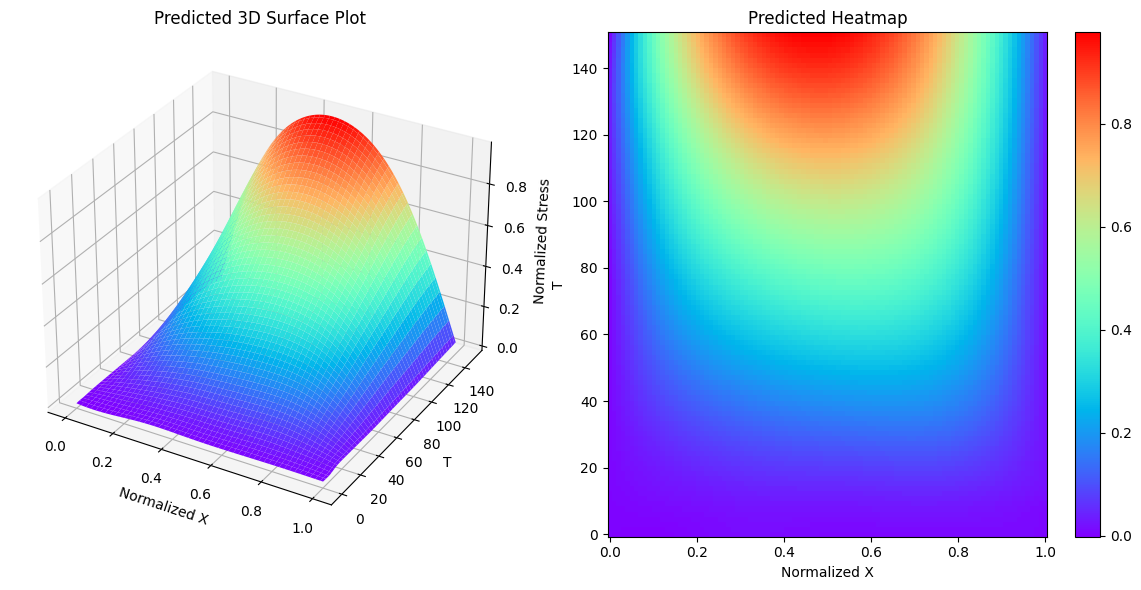

In [ ]:
def plot_stress_vs_x(df, df_pred, t_vals):
    plt.figure(figsize=(10, 6))

    # Loop through each time value in the list
    for t_val in t_vals:
        # Filter the DataFrames for the given t value
        df_filtered = df[df.iloc[:, 1] == t_val]
        df_pred_filtered = df_pred[df_pred.iloc[:, 1] == t_val]

        # Extract the x and stress values
        x_values = df_filtered.iloc[:, 0].values
        stress_values = df_filtered.iloc[:, 2].values
        x_values_pred = df_pred_filtered.iloc[:, 0].values
        stress_values_pred = df_pred_filtered.iloc[:, 2].values

        # Plot the actual and predicted stress for each time value
        plt.plot(x_values, stress_values, label=f'Actual Stress at t={t_val}')
        plt.plot(x_values_pred, stress_values_pred, 'r--', label=f'Predicted Stress at t={t_val}')

    # Customize the plot with labels, title, legend, and grid
    plt.xlabel('r (normalised)')
    plt.ylabel('Radial stress (normalised)')
    plt.title('Radial Stress(r0=300nm & r2=700nm) at Xi=0.5')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot3D_Matrix(x, t, y):
    X, T = x, t
    F_xt = y
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(T, X, F_xt, 20, cmap="rainbow")
    fig.colorbar(cp)  # Add a colorbar to a plot
    ax.set_title('C(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(), cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('C(x,t)')
    plt.show()
    # X, T = x, t[0]
    # F_xt = y

def plot_3d(df, title=""):
    title_surface=f"{title} 3D Surface Plot "
    title_heatmap= f"{title} Heatmap"
    fig = plt.figure(figsize=(12, 6))

    # 3D Surface Plot
    ax1 = fig.add_subplot(121, projection='3d')
    X = df.iloc[:, 0].values
    T = df.iloc[:, 1].values
    Stress = df.iloc[:, 2].values

    # Create meshgrid for plotting
    X_unique = np.unique(X)
    T_unique = np.unique(T)
    X, T = np.meshgrid(X_unique, T_unique)
    Stress = Stress.reshape((len(T_unique), len(X_unique)))

    ax1.plot_surface(X, T, Stress, cmap='rainbow')
    ax1.set_title(title_surface)
    ax1.set_xlabel('Normalized X')
    ax1.set_ylabel('T')
    ax1.set_zlabel('Normalized Stress')

    # Heatmap
    ax2 = fig.add_subplot(122)
    c = ax2.pcolormesh(X, T, Stress, shading='auto', cmap='rainbow')
    fig.colorbar(c, ax=ax2)
    ax2.set_title(title_heatmap)
    ax2.set_xlabel('Normalized X')
    ax2.set_ylabel('T')

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_3d_surface_and_heatmap(df)

t_val = 100
plot_stress_vs_x(df, df_pred, [50,100,150])
plot_3d(df, "Actual")
plot_3d(df_pred, "Predicted")
